# Quantum Evolution Kernal for Earth Observation
This notebook uses `myqlm` as a backend for running the simulations. 
It is requires remote access to a `myqlm` QPU

In [1]:
import qsvm4eo
import numpy as np
import matplotlib.pyplot as plt
from qlmaas.qpus import AnalogQPU
from qat.core import Batch, Schedule
from sklearn.svm import SVC

Please note that with the upcoming maintenance/Qaptiva upgrade on Monday, December 1, 
all temporary files containing Qaptiva results(!) will be deleted.  Make sure to 
download and save all relevant data of your quantum jobs by the end of this week!  

Jobs still in the queue when maintenance starts will also be deleted.  

Output files in your local HOME are not affected.



In [2]:
# Load the data
num_features = 4
x_train, y_train, x_test, y_test, _ = qsvm4eo.load_data(
    data_path="..", num_features=num_features, scale_features=False
)

# Encode the data, transforming the features into qubit coordinates
encoding = qsvm4eo.RadialEncoding(
    max_feature=np.max(x_train), shift=1.0, scaling=5.4, n_features=num_features
)
qbits_train = [encoding.encode(x) for x in x_train]
qbits_test = [encoding.encode(x) for x in x_test]

print("Qubit Geometries:")
print(qbits_train[:4])

Qubit Geometries:
[array([[ 6.49087678e+00,  0.00000000e+00],
       [ 4.35649236e-16,  7.11469194e+00],
       [-7.33116114e+00,  8.97808302e-16],
       [-1.63603526e-15, -8.90616114e+00]]), array([[ 6.27760664e+00,  0.00000000e+00],
       [ 4.00259265e-16,  6.53672986e+00],
       [-7.04004739e+00,  8.62157151e-16],
       [-1.63152989e-15, -8.88163507e+00]]), array([[ 6.35225118e+00,  0.00000000e+00],
       [ 4.10380013e-16,  6.70201422e+00],
       [-7.04004739e+00,  8.62157151e-16],
       [-1.63152989e-15, -8.88163507e+00]]), array([[ 6.30959716e+00,  0.00000000e+00],
       [ 4.07898797e-16,  6.66149289e+00],
       [-7.11895735e+00,  8.71820833e-16],
       [-1.61409609e-15, -8.78672986e+00]])]


In [3]:
def get_probabilities(qbits):
    my_qpu = AnalogQPU()

    # Create jobs
    schedules = [
        Schedule(drive=qsvm4eo.generate_myqlm_hamiltonian(q), tmax=0.66)  # μs,
        for q in qbits
    ]
    jobs = [schedule.to_job() for schedule in schedules]

    # Run jobs
    async_result = my_qpu.submit(Batch(jobs))
    results = async_result.join()

    # Get state probabilities
    return np.array([[r.probability for r in result] for result in results])

In [4]:
probs_train = get_probabilities(qbits_train)
probs_test = get_probabilities(qbits_test)

Submitted a new batch: SJob52819
Submitted a new batch: SJob52820


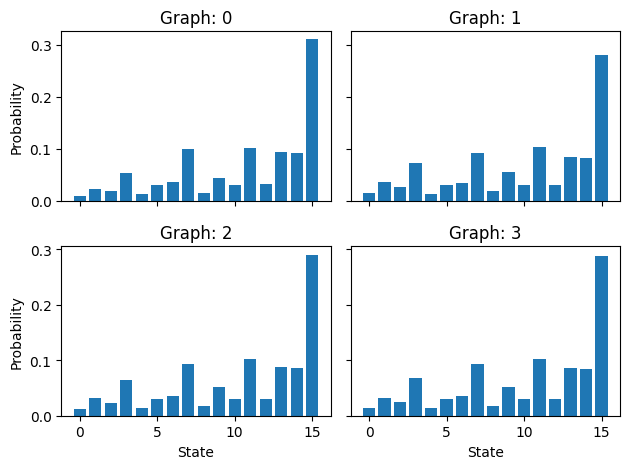

In [5]:
# Plot the probability of the states being measured
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row")

for c in range(4):
    axs[c // 2, c % 2].bar(range(num_features**2), probs_train[c])
    axs[c // 2, c % 2].set_title(f"Graph: {c}")

axs[0, 0].set_ylabel("Probability")
axs[1, 0].set_ylabel("Probability")

axs[1, 0].set_xlabel("State")
axs[1, 1].set_xlabel("State")

plt.tight_layout()
plt.show()

In [6]:
excitations_train = qsvm4eo.compute_excitation_count(probs_train)
excitations_test = qsvm4eo.compute_excitation_count(probs_test)

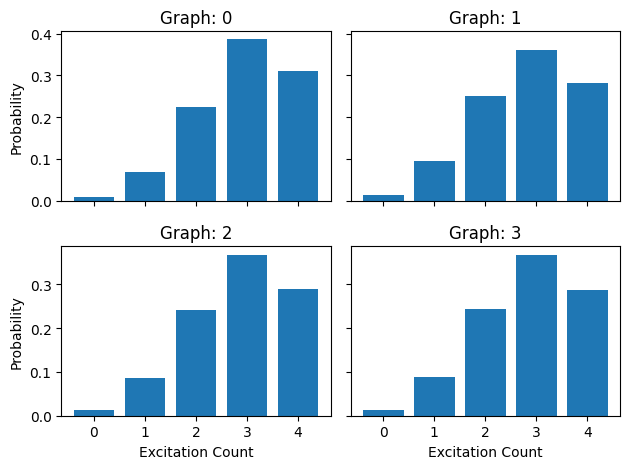

In [7]:
# Plot the probability of the excitations being measured
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row")

for c in range(4):
    axs[c // 2, c % 2].bar(range(num_features + 1), excitations_train[c])
    axs[c // 2, c % 2].set_title(f"Graph: {c}")

axs[0, 0].set_ylabel("Probability")
axs[1, 0].set_ylabel("Probability")

axs[1, 0].set_xlabel("Excitation Count")
axs[1, 1].set_xlabel("Excitation Count")

plt.tight_layout()
plt.show()

# Train SVC

In [8]:
# Compute the kernel
kernel = qsvm4eo.Kernel()
gram_train = kernel.compute_gram_train(excitations_train)

# Fit the SVM and get the score
model = SVC(kernel="precomputed")
model.fit(gram_train, y_train)
train_score = model.score(gram_train, y_train)

# Compute the kernel and score for the test data
gram_test = kernel.compute_gram_test(excitations_test, excitations_train)
test_score = model.score(gram_test, y_test)

print("Train acc:", train_score)
print("Test acc:", test_score)

Train acc: 0.7744140625
Test acc: 0.5087890625
